## Download Files

In [1]:
!rm -rf HRTFCNN
!rm -rf data/cipic_hrtf_sofa
!rm ear.zip
!rm pinnas.zip
!rm -rf binural-updates
!rm -rf CIPIC_hrtf_database

rm: cannot remove 'ear.zip': No such file or directory
rm: cannot remove 'pinnas.zip': No such file or directory


In [2]:
!pip install h5py

In [3]:
%cd /content/

/content


In [4]:
!git clone https://github.com/codyjhsieh/HRTFCNN.git

Cloning into 'HRTFCNN'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 22 (delta 4), reused 17 (delta 3), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [5]:
%cd HRTFCNN

/content/HRTFCNN


In [6]:
!git pull origin master

From https://github.com/codyjhsieh/HRTFCNN
 * branch            master     -> FETCH_HEAD
Already up to date.


In [7]:
!ls

AnthropomorphicFeatures.ipynb  LICENSE	  requirements.txt
data			       README.md  utils


In [8]:
!wget -r -l1 -w 1 --no-parent http://sofacoustics.org/data/database/cipic/

--2018-12-14 14:53:42--  http://sofacoustics.org/data/database/cipic/
Resolving sofacoustics.org (sofacoustics.org)... 193.171.195.16
Connecting to sofacoustics.org (sofacoustics.org)|193.171.195.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘sofacoustics.org/data/database/cipic/index.html’

sofacoustics.org/da     [ <=>                ]  10.13K  --.-KB/s    in 0.002s  

2018-12-14 14:53:42 (5.07 MB/s) - ‘sofacoustics.org/data/database/cipic/index.html’ saved [10370]

Loading robots.txt; please ignore errors.
--2018-12-14 14:53:43--  http://sofacoustics.org/robots.txt
Reusing existing connection to sofacoustics.org:80.
HTTP request sent, awaiting response... 200 OK
Length: 318 [text/plain]
Saving to: ‘sofacoustics.org/robots.txt’

sofacoustics.org/ro 100%[===================>]     318  --.-KB/s    in 0s      

2018-12-14 14:53:43 (37.8 MB/s) - ‘sofacoustics.org/robots.txt’ saved [318/318]

--2018-12-14 14:53:44--  http://

In [9]:
!mkdir data/cipic_hrtf_sofa
!mv sofacoustics.org/data/database/cipic/*.sofa data/cipic_hrtf_sofa
!ls data/cipic_hrtf_sofa | wc -l

45


In [10]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

                          
# 3. Load a file by ID and print its contents.
downloaded = drive.CreateFile({'id': '1a6LihoO2agENYDM6qdpL9tqUa4yQBHTn'})
print('Downloaded pinnas "{}"'.format(downloaded.GetContentFile('pinnas.zip')))

downloaded = drive.CreateFile({'id': '1rJT5NgX_OoI_5_fFxQmjGvxo6ZgFSvN_'})
print('Downloaded images "{}"'.format(downloaded.GetContentFile('ear.zip')))

Downloaded pinnas "None"
Downloaded images "None"


In [11]:
!unzip pinnas.zip
!unzip ear.zip
!mv CIPIC_hrtf_database data
!mv binural-updates/ear_photos data

Archive:  pinnas.zip
   creating: CIPIC_hrtf_database/
  inflating: CIPIC_hrtf_database/read_me.txt  
   creating: CIPIC_hrtf_database/doc/
  inflating: CIPIC_hrtf_database/doc/hrir_data_documentation.pdf  
  inflating: CIPIC_hrtf_database/doc/show_data_manual.pdf  
  inflating: CIPIC_hrtf_database/doc/anthropometry.pdf  
   creating: CIPIC_hrtf_database/special_kemar_hrir/
   creating: CIPIC_hrtf_database/special_kemar_hrir/kemar_frontal/
  inflating: CIPIC_hrtf_database/special_kemar_hrir/kemar_frontal/small_pinna_frontal.mat  
  inflating: CIPIC_hrtf_database/special_kemar_hrir/kemar_frontal/large_pinna_frontal.mat  
  inflating: CIPIC_hrtf_database/special_kemar_hrir/kemar_frontal/read_me.txt  
   creating: CIPIC_hrtf_database/special_kemar_hrir/kemar_horizontal/
  inflating: CIPIC_hrtf_database/special_kemar_hrir/kemar_horizontal/small_pinna_final.mat  
  inflating: CIPIC_hrtf_database/special_kemar_hrir/kemar_horizontal/large_pinna_final.mat  
  inflating: CIPIC_hrtf_database/spe

In [12]:
!ls utils

hrtf.py  image_utils.py


##Load Data

In [0]:
import os
import sys
import scipy.io
import scipy.signal
import logging
import numpy as np
import matplotlib.pyplot as plt
import cv2
from utils.hrtf import *
from utils.image_utils import *

In [0]:
hrtf = CipicHRTF('data/cipic_hrtf_sofa/subject_003.sofa', 44100.0)

In [15]:
print(hrtf.azimuths)

[ 80.  80.  80. ... -80. -80. -80.]


In [0]:
# get pinnas
pinnas = np.array(scipy.io.loadmat('./data/CIPIC_hrtf_database/anthropometry/anthro.mat')['X'])

In [0]:
def get_image(folder, num):
    num_str = str(num)
    if num < 100:
        num_str = '0' + num_str
    if num < 10:
        num_str = '0' + num_str
    num = num_str
    try:
        return plt.imread(folder+ 'Subject_'+str(num)+'/'+str(num)+'_left_side.jpg'), 0
    except:
        try:
            return plt.imread(folder+ 'Subject_'+str(num)+'/'+str(num)+'_right_side.jpg'), 1
        except:
            try:
                return plt.imread(folder+ 'Subject_'+str(num)+'/0'+str(num)+'_left.jpg'), 0
            except:
                try:
                    return plt.imread(folder+ 'Subject_'+str(num)+'/0'+str(num)+'_right.jpg'), 1
                except:
                    try:
                        return plt.imread(folder+ 'Subject_'+str(num)+'/0'+str(num)+'_left.JPG'), 0
                    except:
                        try:
                            return plt.imread(folder+ 'Subject_'+str(num)+'/0'+str(num)+'_right.JPG'), 1
                        except:
                            try:
                                return plt.imread(folder+ 'Subject_'+str(num)+'/Subject_'+str(num)+'_left_side.jpg'), 0
                            except:
                                try:
                                    return plt.imread(folder+ 'Subject_'+str(num)+'/0'+str(num)+'_left_2.jpg'), 0
                                except:
                                    return plt.imread(folder+ 'Subject_'+str(num)+'/00'+str(58)+'_left.jpg'), 0

In [18]:
valid_ranges = []
valid_images = []
valid_final = []
valid_image_ranges = []
for i in range(200):
    try:
        get_hrtf_sofa('data/cipic_hrtf_sofa/', i)
        valid_ranges.append(i)
        try:
            img, ear_num = get_image('data/ear_photos/', i)
            valid_images.append(img)
            valid_image_ranges.append((i, ear_num))
        except FileNotFoundError as err:
            print(err)
            print('Image not Found', i)
            valid_images.append(None)
            valid_image_ranges.append(None)
    except:
        pass
#         print('Failed to load sofa', i)
valid_image_ranges = np.array(valid_image_ranges)

[Errno 2] No such file or directory: 'data/ear_photos/Subject_126/0058_left.jpg'
Image not Found 126
[Errno 2] No such file or directory: 'data/ear_photos/Subject_131/0058_left.jpg'
Image not Found 131
[Errno 2] No such file or directory: 'data/ear_photos/Subject_153/0058_left.jpg'
Image not Found 153
[Errno 2] No such file or directory: 'data/ear_photos/Subject_165/0058_left.jpg'
Image not Found 165


In [19]:
pinna_vals = [pinnas[i] for i, val in enumerate(valid_ranges)]
print(len(valid_ranges))
print(len(pinna_vals))
print(len(valid_images))
print(len(valid_image_ranges))

45
45
45
45


In [20]:
print(valid_image_ranges)

[(3, 1) (8, 0) (9, 0) (10, 0) (11, 1) (12, 1) (15, 0) (17, 1) (18, 0)
 (19, 0) (20, 0) (21, 0) (27, 0) (28, 0) (33, 0) (40, 0) (44, 0) (48, 0)
 (50, 0) (51, 0) (58, 0) (59, 0) (60, 0) (61, 0) (65, 0) (119, 0) (124, 0)
 None (127, 0) None (133, 0) (134, 0) (135, 0) (137, 0) (147, 0) (148, 0)
 (152, 0) None (154, 0) (155, 0) (156, 0) (158, 0) (162, 0) (163, 0) None]


In [0]:
valid_final = np.array(valid_ranges)[~np.isnan(pinna_vals).any(axis=1)]
valid_images = np.array(valid_images)[~np.isnan(pinna_vals).any(axis=1)]
valid_image_ranges = np.array(valid_image_ranges)[~np.isnan(pinna_vals).any(axis=1)]
pinna_vals = np.array(pinna_vals)[~np.isnan(pinna_vals).any(axis=1)]

In [22]:
print(len(valid_final))
print(len(valid_images))
print(len(valid_image_ranges))
print(len(pinna_vals))

35
35
35
35


In [23]:
print(valid_final)
print(valid_image_ranges)

[  3  10  18  20  27  28  33  40  44  48  50  51  58  59  60  61  65 119
 124 126 127 131 133 134 135 137 147 148 152 153 154 155 156 162 163]
[(3, 1) (10, 0) (18, 0) (20, 0) (27, 0) (28, 0) (33, 0) (40, 0) (44, 0)
 (48, 0) (50, 0) (51, 0) (58, 0) (59, 0) (60, 0) (61, 0) (65, 0) (119, 0)
 (124, 0) None (127, 0) None (133, 0) (134, 0) (135, 0) (137, 0) (147, 0)
 (148, 0) (152, 0) None (154, 0) (155, 0) (156, 0) (162, 0) (163, 0)]


In [0]:
valid_images = [valid_images[idx] for idx, val in enumerate(valid_image_ranges) if val is not None]
pinna_vals = [pinna_vals[idx] for idx, val in enumerate(valid_image_ranges) if val is not None]
valid_image_ranges = [valid_image_ranges[idx] for idx, val in enumerate(valid_image_ranges) if val is not None]

In [25]:
print(len(valid_final))
print(len(valid_images))
print(len(valid_image_ranges))
print(len(pinna_vals))

35
32
32
32


In [0]:
impulse_vals = []
for i, ear in valid_image_ranges:
    impulse_vals.append(get_hrtf_sofa('data/cipic_hrtf_sofa/', i).impulses[:,ear,:])




In [27]:
print(impulse_vals)

[array([[-3.11876001e-08,  5.98625888e-07, -3.89598108e-06, ...,
         5.40740803e-05,  2.62411268e-05,  1.30509452e-05],
       [ 8.10463092e-08,  2.48493155e-08, -1.94965401e-06, ...,
         4.63810684e-05,  2.31343438e-05,  1.09934390e-05],
       [-3.85420407e-07,  2.28353770e-06, -1.02743006e-05, ...,
         4.81433999e-05,  2.44446237e-05,  1.10324254e-05],
       ...,
       [ 1.91937399e-08,  5.05269725e-07, -4.96465736e-06, ...,
        -1.03461589e-05, -9.98788455e-05, -5.36835614e-05],
       [ 3.74974547e-07, -1.17730247e-06,  2.28979980e-06, ...,
        -1.99679998e-05, -9.76560477e-05, -5.94681587e-05],
       [ 3.98153617e-07, -1.55144085e-06,  5.02310695e-06, ...,
        -1.43624884e-05, -9.69239481e-05, -5.13568266e-05]]), array([[ 3.27283658e-07, -9.55512178e-07,  4.88718479e-06, ...,
         1.71716920e-06, -3.08660892e-05, -8.58329986e-06],
       [ 3.22508491e-08,  3.10583573e-07,  9.96497306e-07, ...,
         1.18031335e-06, -3.33155003e-05, -8.86985890

In [28]:
print(np.array(impulse_vals).shape)

(32, 1250, 200)


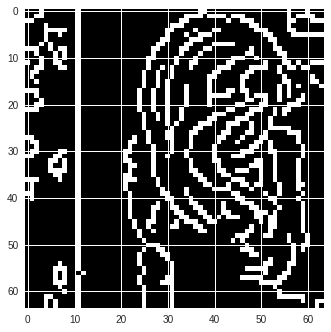

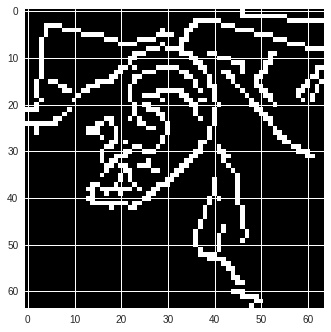

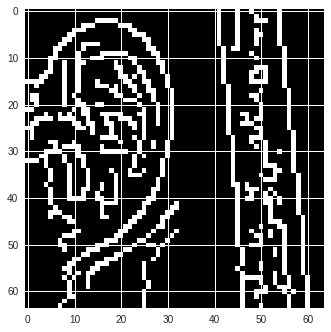

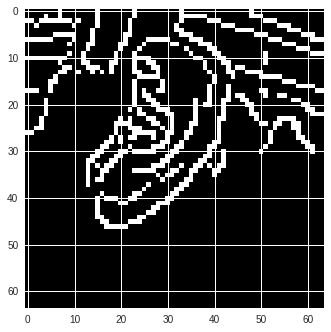

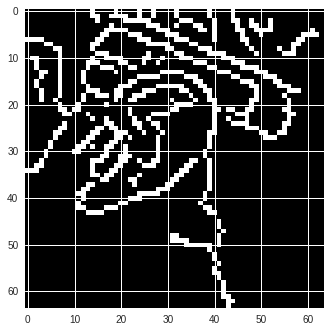

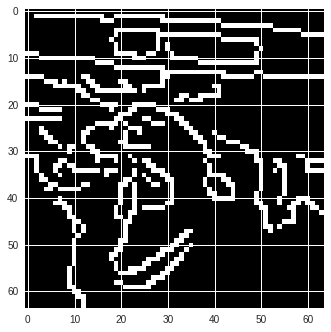

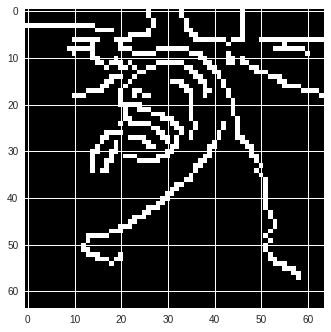

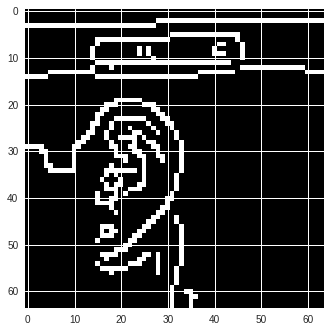

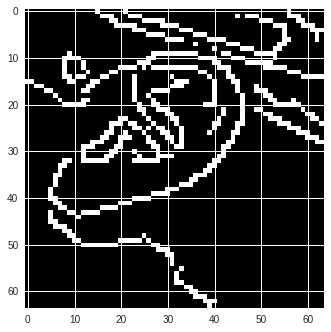

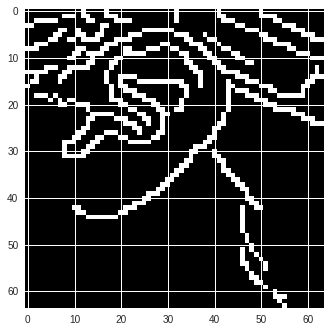

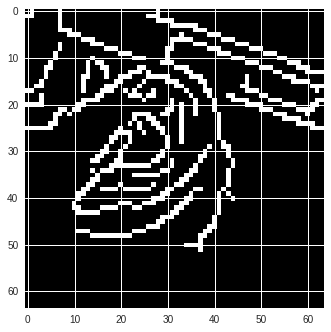

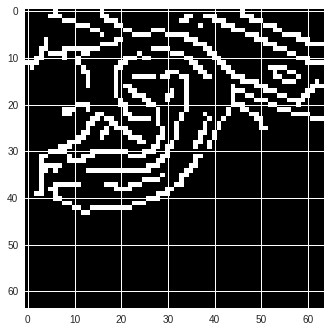

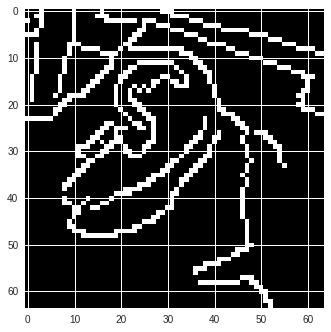

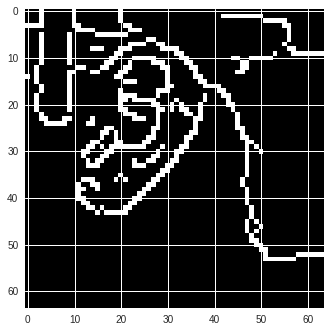

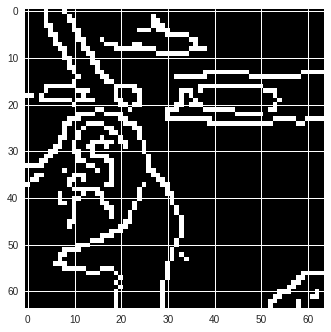

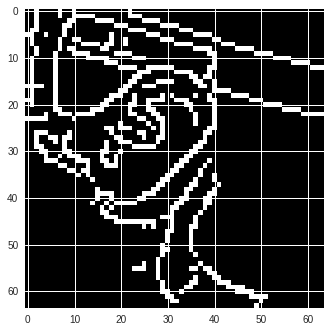

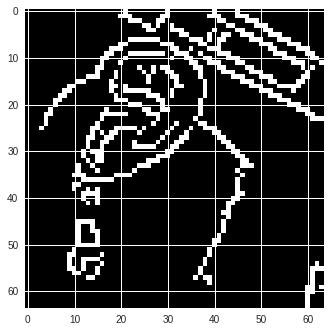

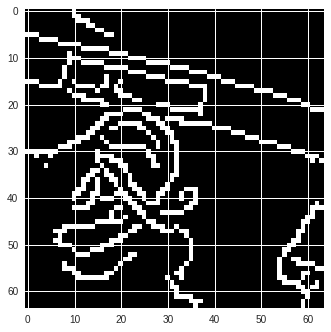

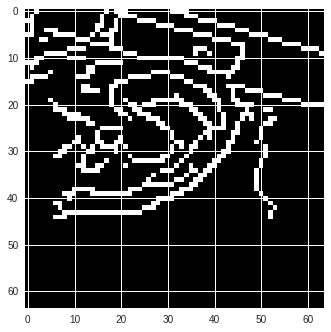

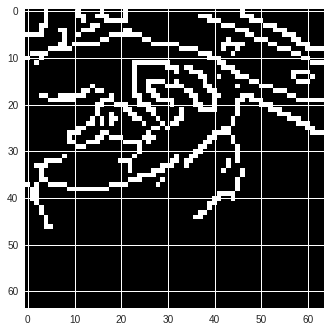

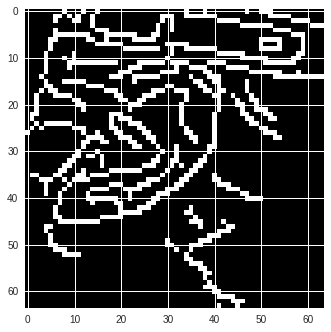

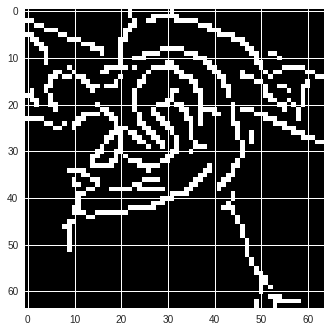

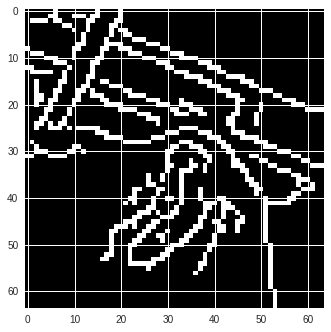

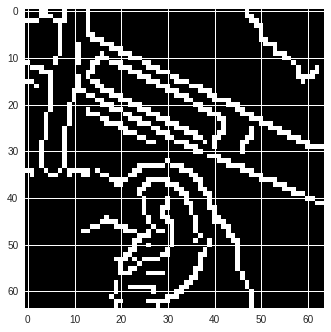

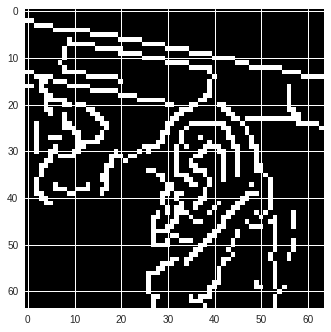

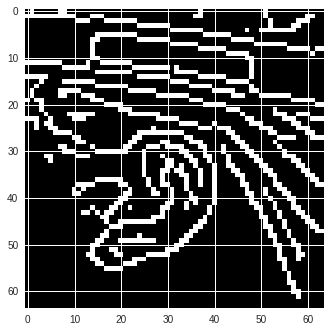

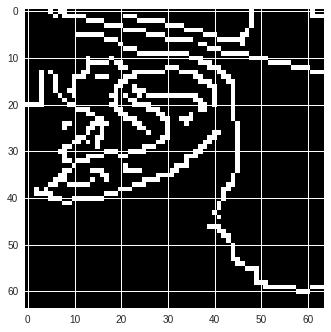

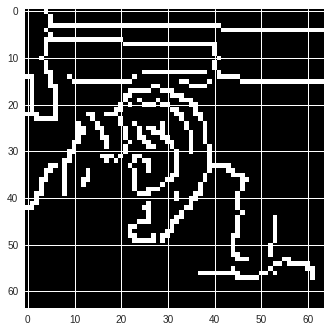

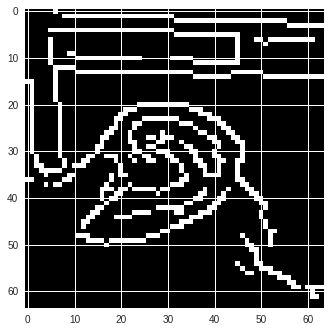

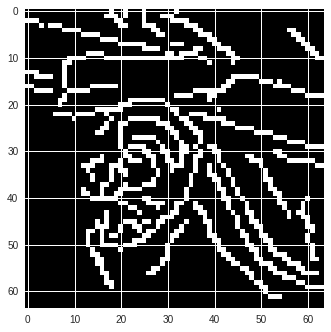

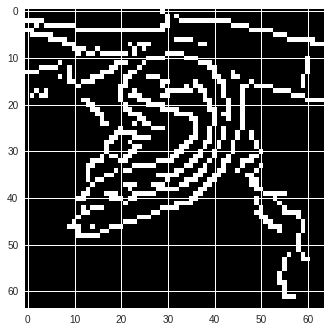

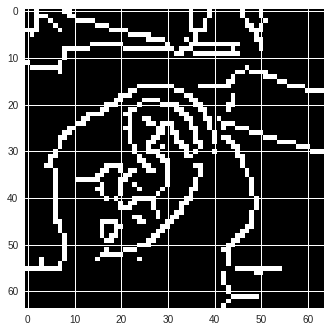

In [29]:
valid_images_canny = []
for i in valid_images:
    valid_images_canny.append(np.expand_dims(get_canny_image(i), axis=2))
    

In [0]:
elevation_vals = get_hrtf_sofa('data/cipic_hrtf_sofa/', 3).elevations
azimuths_vals = get_hrtf_sofa('data/cipic_hrtf_sofa/', 3).azimuths

In [31]:
print(elevation_vals.shape)

(1250,)


In [0]:
hrtf_dataset = []
images_dataset = []
hrtf_Y = []

for idx, person in enumerate(np.array(impulse_vals)):
    for jdx, hrtf in enumerate(person):
        hrtf_dataset.append(np.hstack((elevation_vals[jdx], azimuths_vals[jdx], pinna_vals[idx])))
        images_dataset.append(valid_images_canny[idx])
        hrtf_Y.append(hrtf)

In [0]:
hrtf_dataset = np.array(hrtf_dataset)
hrtf_Y = np.array(hrtf_Y)
images_dataset = np.array(images_dataset)

## Train Model

In [34]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
import time
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D,MaxPooling2D, Flatten, concatenate
# from keras.models import Model
import tensorflow as tf
from keras import backend as K
# from tensorflow.keras import Model

def root_mean_squared_logarithmic_error(y_true, y_pred):
    return 20*K.log(K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))) / K.log(10.0)
    
def get_model():
    main_input = tf.keras.layers.Input(shape=(19,), name='main_input')

    x = tf.keras.layers.Dense(64, activation='relu')(main_input)
    x = tf.keras.layers.Dense(64, activation='relu')(x) 
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    anthro_out = tf.keras.layers.Dense(8, activation='relu')(x)
   
    photo_input = tf.keras.layers.Input(shape=(64,64,1), name='photo_input')
    
    y = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(photo_input)
    y = tf.keras.layers.MaxPooling2D((2, 2))(y)
    y = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(y)
    y = tf.keras.layers.MaxPooling2D((2, 2))(y)
    y = tf.keras.layers.Flatten()(y)
    photo_output = tf.keras.layers.Dense(8, activation='relu')(y)

    z = tf.keras.layers.concatenate([anthro_out, photo_output])
    
    z = tf.keras.layers.Dense(64, activation='relu')(z) 
    z = tf.keras.layers.Dense(64, activation='relu')(z) 
    z = tf.keras.layers.Dense(64, activation='relu')(z) 
    output = tf.keras.layers.Dense(200, activation='relu')(z) 

    return tf.keras.Model(inputs=[main_input, photo_input], outputs=[output])

X_train, X_test, y_train, y_test, image_train, image_test = train_test_split(
    hrtf_dataset, hrtf_Y, images_dataset, test_size=0.33, random_state=42)

dnn_model = get_model()

dnn_model.compile(optimizer=tf.train.AdagradOptimizer(learning_rate=0.1), 
              loss=root_mean_squared_logarithmic_error,
              metrics=[root_mean_squared_logarithmic_error, 'mean_squared_logarithmic_error', 'mse'])

dnn_model.summary()


Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
photo_input (InputLayer)        (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 62, 62, 16)   160         photo_input[0][0]                
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 19)           0                                            
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 31, 31, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dense (Den

In [35]:
use_tpu = True #@param {type:"boolean"}

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''

with tf.Session(TF_MASTER) as session:
  print ('List of devices:')
  print(session.list_devices())

List of devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 10447532823916392890), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 12417415971698378119), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 17733122061412997337), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 8272341097913178804), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 12502244213818456845), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 11754292146091516583), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 15638138077373369996), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 5318330765554578284), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 7331402275452484462), _DeviceAttributes(/job:t

In [36]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    dnn_model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TF_MASTER)))

tpu_model.summary()

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.23.170.138:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10447532823916392890)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 12417415971698378119)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 17733122061412997337)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 8272341097913178804)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 12502244213818456845)
INFO:tensorflow:*** Available Device: _Dev

In [37]:
print(X_train.shape, image_train.shape, y_train.shape)

(26800, 19) (26800, 64, 64, 1) (26800, 200)


In [38]:
history = tpu_model.fit(
  [X_train,image_train], y_train,
  validation_split = 0.2,
  steps_per_epoch = 100,
  validation_steps=50,
  epochs=5,
  shuffle=True
)

Epoch 1/5
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(3350,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(3350, 19), dtype=tf.float32, name='main_input_10'), TensorSpec(shape=(3350, 64, 64, 1), dtype=tf.float32, name='photo_input_10'), TensorSpec(shape=(3350, 200), dtype=tf.float32, name='dense_8_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for main_input
INFO:tensorflow:Remapping placeholder for photo_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.705808401107788 secs
INFO:tensorflow:Setting weights on TPU model.
 99/100 [============================>.] - ETA: 2s - loss: -23.4916 - root_mean_squared_logarithmic_error: -23.4916 - mean_squared_logarithmic_error: 0.0149 - mean_squared_error: 0.1255INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(670,), dtype=tf.int32, name='core_id_10')

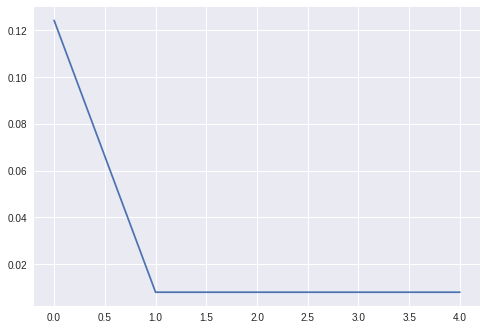

In [47]:
plt.plot(history.history['mean_squared_error'])

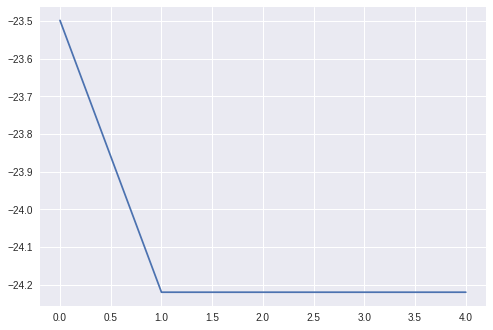

In [48]:
plt.plot(history.history['root_mean_squared_logarithmic_error'])

In [53]:
tpu_model.evaluate([X_test,image_test], y_test,
    steps = 50, verbose=1)


50/50 [==============================] - 47s 932ms/step


[-24.285295486450195,
 -24.285295486450195,
 0.0024178666062653065,
 0.007870934903621674]

In [0]:
tpu_model.save_weights('./hrtf_tpu.h5', overwrite=True)

## Predict

In [56]:
!ls

AnthropomorphicFeatures.ipynb  ear.zip	   README.md	     utils
binural-updates		       LICENSE	   requirements.txt
data			       pinnas.zip  sofacoustics.org


In [0]:
#Enter 17 Measurements Here
anthro = np.array([])

canny_image = np.array([np.expand_dims(get_canny_image(plt.imread('ear_image.jpg')), axis=2)])

In [0]:
tpu_model = load_weights('hrtf_tpu.h5')
cpu_model = tpu_model.sync_to_cpu()
final_impulses = []
for i in hrtf.elevation:
    for j in hrtf.azimuths:
        final_impulses.append(cpu_model.predict([np.hstack(anthro, i, j), canny_image])[0])

In [0]:
elevations, azimuths = interauralPolarToVerticalPolarCoordinates(hrtf.elevations, hrtf.azimuths)
create_cipic_hrtf('data/template.sofa', 'data/predict.sofa', final_impulses, hrtf.elevations, hrtf.azimuths)

In [0]:
from google.colab import files
files.download('data/predict.sofa')